# XGBoost Evaluation on New TEP Dataset

This notebook evaluates the trained XGBoost model on the newly generated independent TEP dataset.

**Purpose**: Test model generalization on completely unseen data generated from `tep-sim`.

**Model**: XGBoost (multiclass fault classification)

**Evaluation Dataset**: `data/new_multiclass_eval.csv` (generated by notebook 03)

**Outputs**:
- Metrics: `outputs/metrics/xgboost_new_eval_metrics.json`
- Confusion matrix: `outputs/figures/xgboost_new_eval_confusion_matrix.png`
- Per-class F1: `outputs/figures/xgboost_new_eval_per_class_f1.png`

## Configuration & Imports

In [1]:
import os
import json
import pickle
import time
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Paths
DATA_DIR = Path('../data')
MODEL_DIR = Path('../outputs/models')
METRICS_DIR = Path('../outputs/metrics')
FIGURES_DIR = Path('../outputs/figures')

# Ensure output directories exist
METRICS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Detect which dataset is available (quick vs full)
QUICK_MODE = False
if (DATA_DIR / 'new_multiclass_eval_quick.csv').exists():
    if not (DATA_DIR / 'new_multiclass_eval.csv').exists():
        QUICK_MODE = True
    else:
        # Both exist - check which is newer or use environment variable
        quick_mtime = (DATA_DIR / 'new_multiclass_eval_quick.csv').stat().st_mtime
        full_mtime = (DATA_DIR / 'new_multiclass_eval.csv').stat().st_mtime
        QUICK_MODE = quick_mtime > full_mtime

# Allow environment variable override
if os.environ.get('QUICK_MODE', '').lower() in ('true', '1', 'yes'):
    QUICK_MODE = True

FILE_SUFFIX = '_quick' if QUICK_MODE else ''

print("="*60)
print("XGBoost Evaluation on New TEP Dataset")
if QUICK_MODE:
    print("⚡ QUICK MODE - Using limited test dataset")
print("="*60)

XGBoost Evaluation on New TEP Dataset


## Load Trained Model

In [2]:
print("\n[Step 1/5] Loading trained XGBoost model...")

model_path = MODEL_DIR / 'xgboost_final.pkl'
with open(model_path, 'rb') as f:
    model_data = pickle.load(f)

model = model_data['model']
scaler = model_data['scaler']
label_encoder = model_data['label_encoder']
features = model_data['features']

print(f"✓ Model loaded from {model_path}")
print(f"  Features: {len(features)}")
print(f"  Classes: {len(label_encoder.classes_)} ({list(label_encoder.classes_)})")

# Load original metrics for comparison
orig_metrics_path = METRICS_DIR / 'xgboost_metrics.json'
with open(orig_metrics_path) as f:
    orig_metrics = json.load(f)
print(f"✓ Original metrics loaded for comparison")


[Step 1/5] Loading trained XGBoost model...


✓ Model loaded from ../outputs/models/xgboost_final.pkl
  Features: 52
  Classes: 18 ([np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(16.0), np.float64(17.0), np.float64(18.0), np.float64(19.0), np.float64(20.0)])
✓ Original metrics loaded for comparison


## Load New Evaluation Dataset

In [3]:
print("\n[Step 2/5] Loading new evaluation dataset...")
start_time = time.time()

eval_file = DATA_DIR / f'new_multiclass_eval{FILE_SUFFIX}.csv'
eval_data = pd.read_csv(eval_file)

print(f"✓ Dataset loaded in {time.time() - start_time:.2f}s")
print(f"  File: {eval_file.name}")
print(f"  Shape: {eval_data.shape}")
print(f"  Classes: {sorted(eval_data['faultNumber'].unique())}")
print(f"  Samples per class: ~{eval_data.groupby('faultNumber').size().iloc[0]:,}")


[Step 2/5] Loading new evaluation dataset...


✓ Dataset loaded in 15.85s
  File: new_multiclass_eval.csv
  Shape: (1978215, 57)
  Classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20)]
  Samples per class: ~120,150


## Preprocess Data

In [4]:
print("\n[Step 3/5] Preprocessing data...")

# Extract features
X_eval = eval_data[features].values
y_eval_raw = eval_data['faultNumber'].values

# Apply same scaling as training
X_eval_scaled = scaler.transform(X_eval)

# Encode labels (same encoding as training)
y_eval = label_encoder.transform(y_eval_raw)

# Get class names
class_names = [str(int(c)) for c in label_encoder.classes_]
num_classes = len(class_names)

print(f"✓ Features scaled: {X_eval_scaled.shape}")
print(f"✓ Labels encoded: {y_eval.shape}")
print(f"✓ Number of classes: {num_classes}")


[Step 3/5] Preprocessing data...


✓ Features scaled: (1978215, 52)
✓ Labels encoded: (1978215,)
✓ Number of classes: 18


## Generate Predictions

In [5]:
print("\n[Step 4/5] Generating predictions...")
pred_start = time.time()

y_pred = model.predict(X_eval_scaled)
y_pred_proba = model.predict_proba(X_eval_scaled)

print(f"✓ Predictions generated in {time.time() - pred_start:.2f}s")
print(f"  Predictions shape: {y_pred.shape}")
print(f"  Probability shape: {y_pred_proba.shape}")


[Step 4/5] Generating predictions...


✓ Predictions generated in 6.87s
  Predictions shape: (1978215,)
  Probability shape: (1978215, 18)


## Compute Evaluation Metrics

In [6]:
print("\n[Step 5/5] Computing evaluation metrics...")

# Core metrics
accuracy = accuracy_score(y_eval, y_pred)
balanced_acc = balanced_accuracy_score(y_eval, y_pred)
f1_weighted = f1_score(y_eval, y_pred, average='weighted')
f1_macro = f1_score(y_eval, y_pred, average='macro')
precision_weighted = precision_score(y_eval, y_pred, average='weighted')
recall_weighted = recall_score(y_eval, y_pred, average='weighted')

# Per-class F1
f1_per_class = f1_score(y_eval, y_pred, average=None)

# Confusion matrix
cm = confusion_matrix(y_eval, y_pred)

print("\n" + "="*60)
print("NEW EVALUATION DATASET RESULTS")
if QUICK_MODE:
    print("(Quick mode - limited samples per class)")
print("="*60)
print(f"Accuracy:          {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"F1 (weighted):     {f1_weighted:.4f}")
print(f"F1 (macro):        {f1_macro:.4f}")
print(f"Precision:         {precision_weighted:.4f}")
print(f"Recall:            {recall_weighted:.4f}")
print("="*60)


[Step 5/5] Computing evaluation metrics...



NEW EVALUATION DATASET RESULTS
Accuracy:          0.8940 (89.40%)
Balanced Accuracy: 0.8960
F1 (weighted):     0.8973
F1 (macro):        0.9007
Precision:         0.9045
Recall:            0.8940


In [7]:
# Compare with original test set performance
print("\nComparison with Original Test Set:")
print("-" * 50)
print(f"{'Metric':<20} {'Original':>12} {'New Eval':>12} {'Delta':>10}")
print("-" * 50)

comparisons = [
    ('Accuracy', orig_metrics['accuracy'], accuracy),
    ('Balanced Acc', orig_metrics['balanced_accuracy'], balanced_acc),
    ('F1 (weighted)', orig_metrics['f1_weighted'], f1_weighted),
    ('F1 (macro)', orig_metrics['f1_macro'], f1_macro),
    ('Precision', orig_metrics['precision_weighted'], precision_weighted),
    ('Recall', orig_metrics['recall_weighted'], recall_weighted),
]

for metric_name, orig_val, new_val in comparisons:
    delta = new_val - orig_val
    delta_str = f"{delta:+.4f}"
    print(f"{metric_name:<20} {orig_val:>12.4f} {new_val:>12.4f} {delta_str:>10}")

print("-" * 50)


Comparison with Original Test Set:
--------------------------------------------------
Metric                   Original     New Eval      Delta
--------------------------------------------------
Accuracy                   0.9391       0.8940    -0.0451
Balanced Acc               0.9391       0.8960    -0.0431
F1 (weighted)              0.9416       0.8973    -0.0443
F1 (macro)                 0.9416       0.9007    -0.0409
Precision                  0.9484       0.9045    -0.0438
Recall                     0.9391       0.8940    -0.0451
--------------------------------------------------


In [8]:
# Detailed classification report
print("\nPer-Class Classification Report:")
print(classification_report(y_eval, y_pred, target_names=class_names, digits=4))


Per-Class Classification Report:


              precision    recall  f1-score   support

           0     0.5541    0.7106    0.6227    120150
           1     0.9965    0.9895    0.9930    120150
           2     0.9982    0.9857    0.9919    120150
           4     0.9471    0.9599    0.9535    120150
           5     0.7203    0.8518    0.7806    120150
           6     1.0000    0.9910    0.9955     17883
           7     1.0000    0.9986    0.9993    120150
           8     0.9724    0.9272    0.9492    120150
          10     0.8515    0.8123    0.8314    120150
          11     0.9332    0.8294    0.8782    120150
          12     0.8850    0.9319    0.9079    109829
          13     0.9833    0.9035    0.9417    118055
          14     0.9925    0.9598    0.9759    120150
          16     0.9669    0.8123    0.8829    120150
          17     0.9518    0.9321    0.9418    120150
          18     0.9074    0.8078    0.8547     50348
          19     0.9422    0.8952    0.9181    120150
          20     0.7620    

## Visualizations

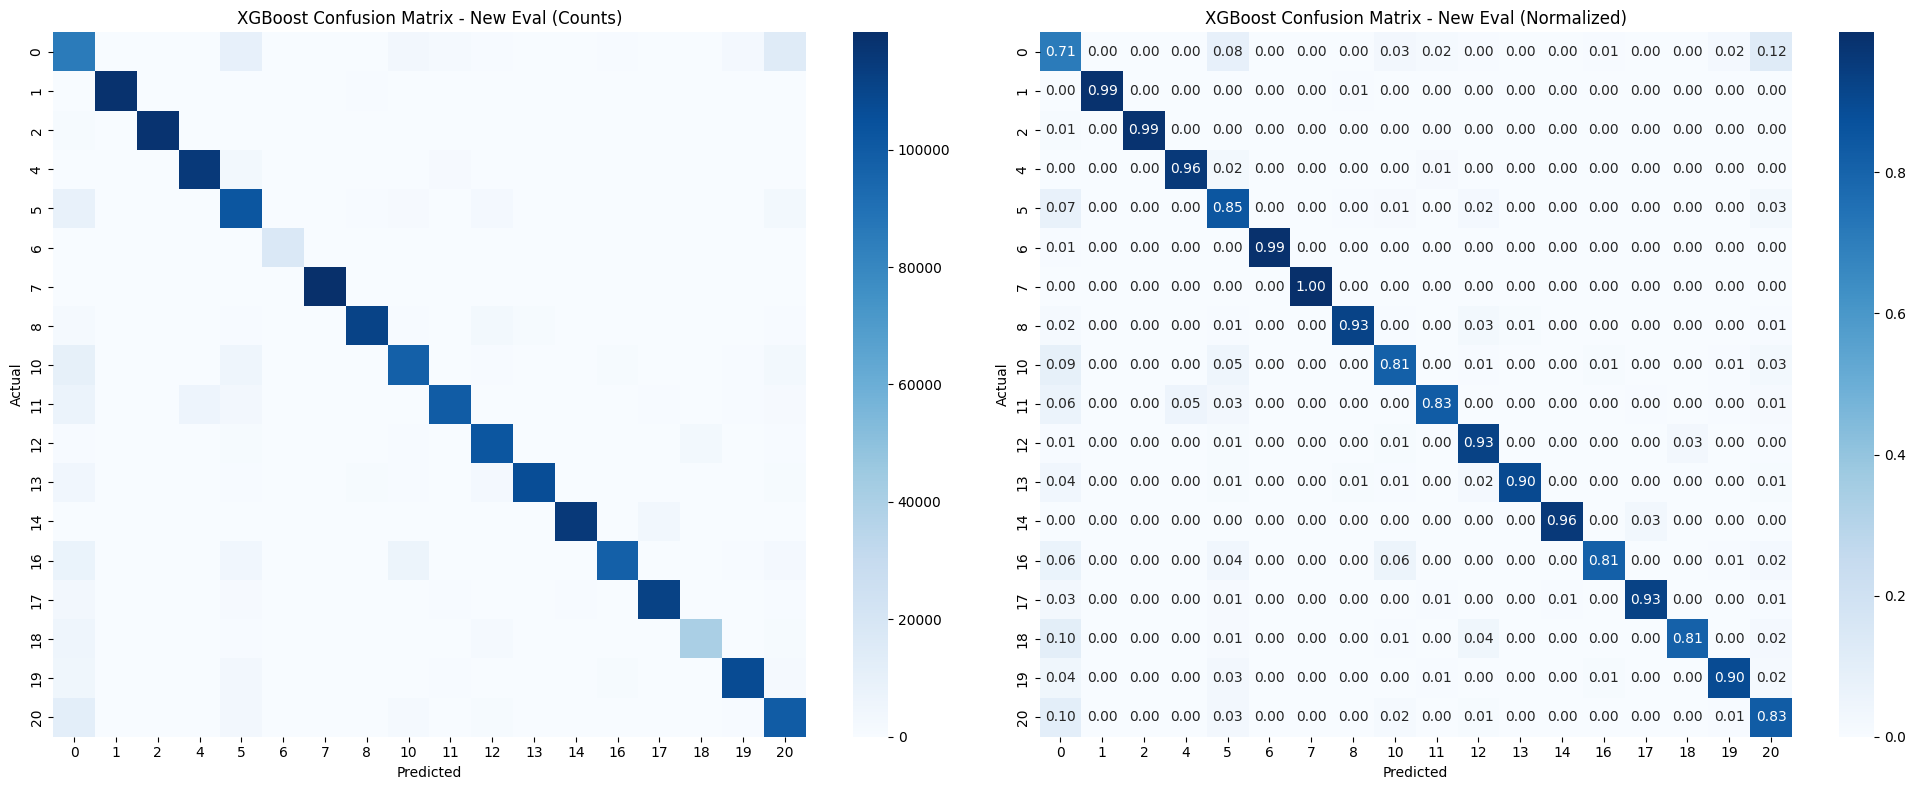

✓ Saved to ../outputs/figures/xgboost_new_eval_confusion_matrix.png


In [9]:
# Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Raw counts
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('XGBoost Confusion Matrix - New Eval (Counts)')

# Normalized (percentages)
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('XGBoost Confusion Matrix - New Eval (Normalized)')

plt.tight_layout()
output_file = FIGURES_DIR / f'xgboost_new_eval_confusion_matrix{FILE_SUFFIX}.png'
plt.savefig(output_file, dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved to {output_file}")

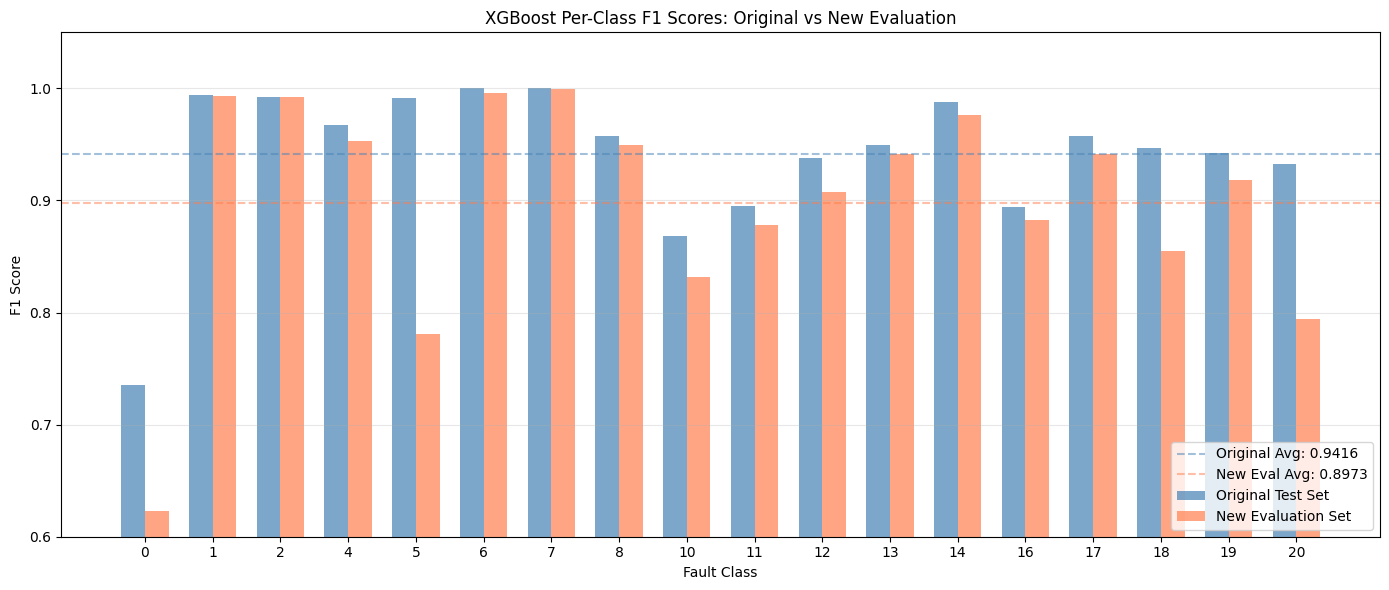

✓ Saved to ../outputs/figures/xgboost_new_eval_per_class_f1.png


In [10]:
# Per-class F1 comparison with original
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(class_names))
width = 0.35

# Original test set F1
orig_f1_per_class = [orig_metrics['per_class_f1'][c] for c in class_names]

bars1 = ax.bar(x - width/2, orig_f1_per_class, width, label='Original Test Set', color='steelblue', alpha=0.7)
bars2 = ax.bar(x + width/2, f1_per_class, width, label='New Evaluation Set', color='coral', alpha=0.7)

ax.axhline(y=orig_metrics['f1_weighted'], color='steelblue', linestyle='--', alpha=0.5, 
           label=f'Original Avg: {orig_metrics["f1_weighted"]:.4f}')
ax.axhline(y=f1_weighted, color='coral', linestyle='--', alpha=0.5,
           label=f'New Eval Avg: {f1_weighted:.4f}')

ax.set_xlabel('Fault Class')
ax.set_ylabel('F1 Score')
ax.set_title('XGBoost Per-Class F1 Scores: Original vs New Evaluation')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend(loc='lower right')
ax.set_ylim(0.6, 1.05)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
output_file = FIGURES_DIR / f'xgboost_new_eval_per_class_f1{FILE_SUFFIX}.png'
plt.savefig(output_file, dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved to {output_file}")

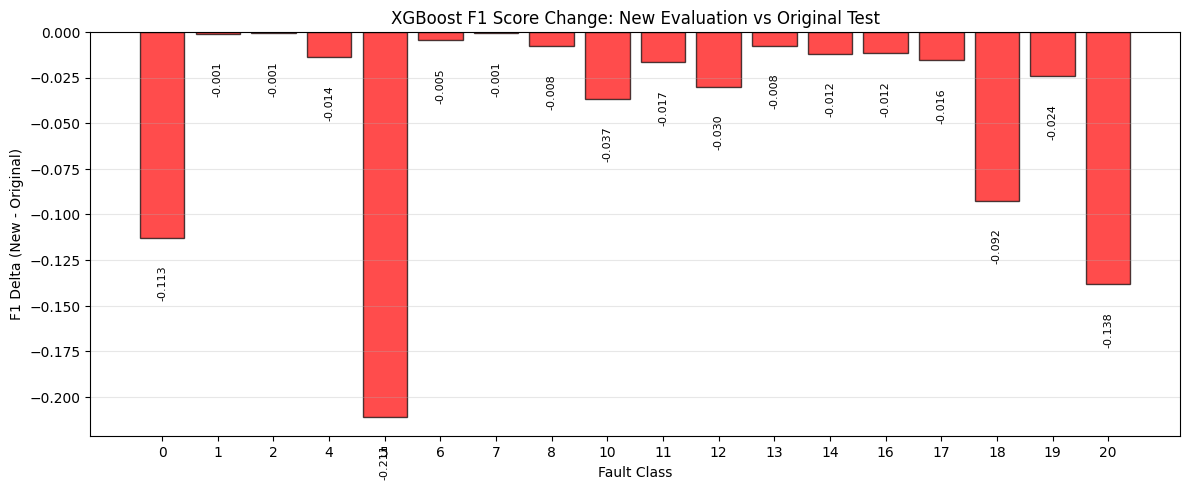

✓ Saved to ../outputs/figures/xgboost_new_eval_f1_delta.png


In [11]:
# F1 Delta plot (New - Original)
fig, ax = plt.subplots(figsize=(12, 5))

deltas = f1_per_class - np.array(orig_f1_per_class)
colors = ['green' if d >= 0 else 'red' for d in deltas]

bars = ax.bar(class_names, deltas, color=colors, edgecolor='black', alpha=0.7)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

ax.set_xlabel('Fault Class')
ax.set_ylabel('F1 Delta (New - Original)')
ax.set_title('XGBoost F1 Score Change: New Evaluation vs Original Test')
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar, delta in zip(bars, deltas):
    ypos = bar.get_height() + 0.005 if delta >= 0 else bar.get_height() - 0.015
    ax.text(bar.get_x() + bar.get_width()/2, ypos, f'{delta:+.3f}', 
            ha='center', va='bottom' if delta >= 0 else 'top', fontsize=8, rotation=90)

plt.tight_layout()
output_file = FIGURES_DIR / f'xgboost_new_eval_f1_delta{FILE_SUFFIX}.png'
plt.savefig(output_file, dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved to {output_file}")

## Save Results

In [12]:
# Compile all metrics
new_eval_metrics = {
    'model': 'XGBoost',
    'dataset': f'new_multiclass_eval{FILE_SUFFIX}',
    'task': 'multiclass',
    'quick_mode': QUICK_MODE,
    'num_samples': len(y_eval),
    'num_classes': num_classes,
    'accuracy': float(accuracy),
    'balanced_accuracy': float(balanced_acc),
    'f1_weighted': float(f1_weighted),
    'f1_macro': float(f1_macro),
    'precision_weighted': float(precision_weighted),
    'recall_weighted': float(recall_weighted),
    'per_class_f1': {class_names[i]: float(f1_per_class[i]) for i in range(num_classes)},
    'comparison_with_original': {
        'accuracy_delta': float(accuracy - orig_metrics['accuracy']),
        'f1_weighted_delta': float(f1_weighted - orig_metrics['f1_weighted']),
        'original_accuracy': orig_metrics['accuracy'],
        'original_f1_weighted': orig_metrics['f1_weighted']
    }
}

# Save metrics
output_file = METRICS_DIR / f'xgboost_new_eval_metrics{FILE_SUFFIX}.json'
with open(output_file, 'w') as f:
    json.dump(new_eval_metrics, f, indent=2)
print(f"✓ Saved metrics to {output_file}")

# Save confusion matrix
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_file = METRICS_DIR / f'xgboost_new_eval_confusion_matrix{FILE_SUFFIX}.csv'
cm_df.to_csv(cm_file)
print(f"✓ Saved confusion matrix to {cm_file}")

✓ Saved metrics to ../outputs/metrics/xgboost_new_eval_metrics.json
✓ Saved confusion matrix to ../outputs/metrics/xgboost_new_eval_confusion_matrix.csv


In [13]:
print("\n" + "="*60)
print("XGBoost New Data Evaluation Complete!")
if QUICK_MODE:
    print("(Quick mode)")
print("="*60)
print(f"\nSummary:")
print(f"  Evaluation samples: {len(y_eval):,}")
print(f"  Accuracy: {accuracy:.4f} (original: {orig_metrics['accuracy']:.4f}, delta: {accuracy - orig_metrics['accuracy']:+.4f})")
print(f"  F1 (weighted): {f1_weighted:.4f} (original: {orig_metrics['f1_weighted']:.4f}, delta: {f1_weighted - orig_metrics['f1_weighted']:+.4f})")
print("\nOutputs:")
print(f"  - {METRICS_DIR / f'xgboost_new_eval_metrics{FILE_SUFFIX}.json'}")
print(f"  - {FIGURES_DIR / f'xgboost_new_eval_confusion_matrix{FILE_SUFFIX}.png'}")
print(f"  - {FIGURES_DIR / f'xgboost_new_eval_per_class_f1{FILE_SUFFIX}.png'}")
print(f"  - {FIGURES_DIR / f'xgboost_new_eval_f1_delta{FILE_SUFFIX}.png'}")
print("="*60)


XGBoost New Data Evaluation Complete!

Summary:
  Evaluation samples: 1,978,215
  Accuracy: 0.8940 (original: 0.9391, delta: -0.0451)
  F1 (weighted): 0.8973 (original: 0.9416, delta: -0.0443)

Outputs:
  - ../outputs/metrics/xgboost_new_eval_metrics.json
  - ../outputs/figures/xgboost_new_eval_confusion_matrix.png
  - ../outputs/figures/xgboost_new_eval_per_class_f1.png
  - ../outputs/figures/xgboost_new_eval_f1_delta.png
